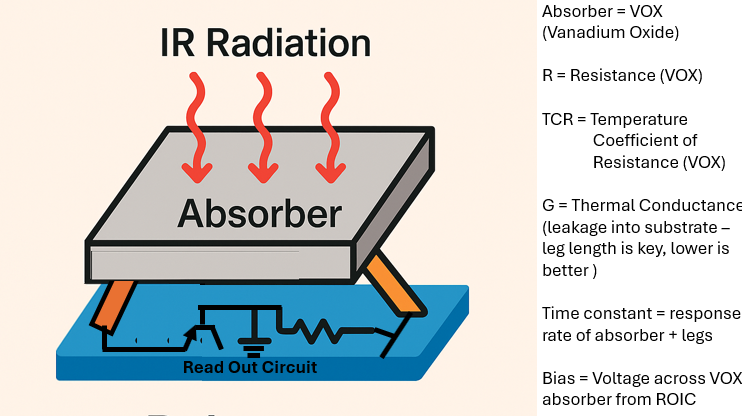
## Bolometer Calculator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, FloatText, Layout, HTML
from IPython.display import display

# --- Constants ---
h = 6.626e-34  # Planck [J·s]
c = 3.0e8      # Speed of light [m/s]
kB = 1.38e-23  # Boltzmann [J/K]

# Seed initial temp for slider defaults
#Tbb_input = 300

# --- Photon flux spectral radiance [ph/s/m²/µm/sr] (for display only) ---
def planck_photon_flux(wl_um, T):
    wl_m = wl_um * 1e-6
    exponent = h * c / (wl_m * kB * T)
    spectral_radiance = (2 * h * c**2) / (wl_m**5 * (np.exp(exponent) - 1))  # W/m^2/sr/m
    photon_energy = h * c / wl_m                                            # J
    return spectral_radiance / photon_energy                                 # ph/s/m^2/sr/m

# --- Band-integrated photon flux to pixel [ph/s] (for display only) ---
def compute_photon_flux(WL1, WL2, T, f_number, transmission, pixel_pitch_um):
    wl = np.linspace(WL1, WL2, 2000)                # µm
    phi = planck_photon_flux(wl, T)                 # ph/s/m^2/sr/m
    phi = phi * 1e-6                                # -> ph/s/m^2/sr/µm
    omega = np.pi / (4 * f_number**2)               # sr
    area = (pixel_pitch_um * 1e-6)**2               # m^2
    return np.trapezoid(phi, wl) * omega * area * transmission  # ph/s

# --- Band-integrated incident power to pixel [W] ---
def compute_incident_power(WL1, WL2, f_number, transmission, pixel_pitch_um, Tbb):
    wl = np.linspace(WL1, WL2, 2000)                # µm
    wl_m = wl * 1e-6                                 # m
    exponent = h * c / (wl_m * kB * Tbb)
    L_lambda = (2 * h * c**2 / wl_m**5) / (np.exp(exponent) - 1)  # W/m^2/sr/m
    L_um = L_lambda * 1e-6                           # W/m^2/sr/µm
    omega = np.pi / (4 * f_number**2)               # sr
    area = (pixel_pitch_um * 1e-6)**2               # m^2
    return np.trapezoid(L_um, wl) * omega * area * transmission  # W (incident on pixel)


# --- Main NETD and plot model (radiometric chain + frame-rate & thermal roll-off) ---
def bolometer_model_with_plot(
    WL1, WL2, f_number, transmission, pixel_pitch,
    G, R, Toper,
    Tbb_input, frame_rate, duty_cycle, tau_th,
    alpha_TCR, Vbias,
    Tbb_cursor
):
    # Fixed sweep range and fixed axes
    XMIN, XMAX = Tbb_input*0.75, Tbb_input*1.25
    T_range = np.linspace(XMIN, XMAX, 100)

    # Absorber/optics efficiency
    Absorptivity = 1.0 #dont need this here.  Combine BB emissivity and atmospheric trans and window trans = trans
    eta = Absorptivity * transmission          # fraction of incident power absorbed

    # --- Noise sources in W/√Hz ---
    NEP_phonon = np.sqrt(4 * kB * Toper**2 * G)   # W/√Hz

    # --- Frame-rate / integrate-reset effects ---
    T_int = max(1e-6, duty_cycle / max(1e-3, frame_rate))  # s, guard
    B_eq = 1.0 / (2.0 * T_int)                             # Hz (ENBW of boxcar)
    noise_bw_scale = np.sqrt(B_eq)                         # scales NEP to W over B_eq

    # --- Thermal roll-off on responsivity ---
    f_sig = 0.5 * frame_rate
    H_th = 1.0 / np.sqrt(1.0 + (2.0 * np.pi * f_sig * tau_th)**2) if tau_th > 0 else 1.0

    # --- Voltage responsivity S_V [V/W]; convert Johnson noise to W/√Hz ---
    # S_V ≈ (η * α * Vbias / G) * H_th
    S_V = (eta * alpha_TCR * Vbias / max(G, 1e-30)) * H_th

    v_j = np.sqrt(4 * kB * Toper * R)                 # V/√Hz
    NEP_johnson = v_j / max(S_V, 1e-30)               # W/√Hz

    # Total NEP (spectral density) -> RMS over ENBW
    NEP_total_W = np.sqrt(NEP_phonon**2 + NEP_johnson**2) * noise_bw_scale  # W

    # --- Helper: dP/dTbb (W/K) via numerical derivative of incident power ---
    dT = 2.0
    def dP_dTbb(T):
        P_hi = compute_incident_power(WL1, WL2, f_number, transmission, pixel_pitch, T + dT)
        P_lo = compute_incident_power(WL1, WL2, f_number, transmission, pixel_pitch, T - dT)
        # Absorbed power derivative
        return eta * (P_hi - P_lo) / (2 * dT)   # W/K

    # --- NETD in kelvins; convert to mK only for plotting/display ---
    def netd_at_K(T):
        dPdt = dP_dTbb(T)                        # W/K
        NETD_K = NEP_total_W / max(dPdt, 1e-30)  # K
        return NETD_K, dPdt

    # Curve (mK for y-axis)
    netd_vals_mK = np.array([netd_at_K(T)[0] * 1e3 for T in T_range])

    # Cursor point
    netd_cursor_K, dPdt_cursor = netd_at_K(Tbb_cursor)
    netd_cursor_mK = netd_cursor_K * 1e3

    # For display: power & photon flux at cursor
    power_cursor = compute_incident_power(WL1, WL2, f_number, transmission, pixel_pitch, Tbb_cursor)
    wl = np.linspace(WL1, WL2, 2000)
    phi_spectral = planck_photon_flux(wl, Tbb_cursor) * 1e-6   # ph/s/m^2/sr/µm
    omega = np.pi / (4 * f_number**2)
    phi_per_m2 = np.trapezoid(phi_spectral, wl) * omega * transmission  # ph/s/m^2
    phi_per_cm2 = phi_per_m2 / 1e4

    # Y-limits
    y_min, y_max = netd_vals_mK.min(), netd_vals_mK.max()
    pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
    y_lo, y_hi = max(0, y_min - pad), y_max + pad

    # --- Plot ---
    plt.style.use('classic')
    plt.figure(figsize=(11, 7))
    plt.plot(T_range, netd_vals_mK, label='NETD vs Tbb (mK)')

    plt.axhline(y=netd_cursor_mK, color='gray', linestyle='--', linewidth=1,
                label=f'NETD = {netd_cursor_mK:.2f} mK')
    plt.axvline(x=Tbb_cursor, color='gray', linestyle='--', linewidth=1,
                label=f'Tbb = {Tbb_cursor:.0f} K')
    plt.plot(Tbb_cursor, netd_cursor_mK, 'k*', markersize=12, label='Cursor Temp')

    # Reference marker at text input Tbb
    plt.plot(Tbb_input, netd_at_K(Tbb_input)[0]*1e3, 'rD', markersize=8, label='Ref Temp')

    plt.xlabel("Blackbody Temperature (K)")
    plt.ylabel("NETD (mK)")
    plt.title("Bolometer NETD vs Blackbody Temperature (radiometric, with frame-rate & τ roll-off)")
    plt.grid(True)
    plt.xlim(XMIN, XMAX)
    plt.ylim(0, y_hi)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Display ---
    display(HTML(
        f"<p style='font-size:14pt'><b>CALCULATED RESULTS (Cursor):</b></p>"
        f"<b>Cursor Tbb (slider):</b> {Tbb_cursor:.0f} K<br>"
        f"<b>NETD:</b> {netd_cursor_K:.3e} K = {netd_cursor_mK:.2f} mK<br>"
        f"<b>dP/dTbb (absorbed):</b> {dPdt_cursor:.3e} W/K<br>"
        f"<b>Total NEP over ENBW:</b> {NEP_total_W:.3e} W (B_eq={B_eq:.1f} Hz)<br>"
        #f"&nbsp;&nbsp;&nbsp;• NEP_phonon (per √Hz): {np.sqrt(4*kB*Toper**2*G):.3e} W/√Hz<br>"
        #f"&nbsp;&nbsp;&nbsp;• NEP_Johnson (per √Hz): {NEP_johnson:.3e} W/√Hz (S_V={S_V:.2e} V/W)<br>"
        f"<b>Effective Integration Time T_int:</b> {T_int*1e3:.2f} ms<br>"
        #f"<b>Thermal roll-off H_th (at {f_sig:.1f} Hz):</b> {H_th:.3f}<br>"
        f"<b>Incident Power:</b> {power_cursor:.3e} W<br>"
        f"<b>Incident Photon Flux:</b> {phi_per_cm2:.3e} ph/s/cm²<br>"
    ))


    # --- UI ---
style1 = {'description_width': 'initial'}
layout = Layout(width='300px')

interact(
    bolometer_model_with_plot,
    WL1=FloatText(value=8.0, description='λ₁ (µm)', style=style1),
    WL2=FloatText(value=14.0, description='λ₂ (µm)', style=style1),
    f_number=FloatText(value=1.0, description='f/#', style=style1),
    transmission=FloatText(value=0.8, description='Transmission', style=style1),
    pixel_pitch=FloatText(value=17, description='Pixel Pitch (µm)', style=style1),

    # Typical starting points (adjust to your device)
    G=FloatText(value=2e-7, description='G (W/K)', style=style1),
    R=FloatText(value=3e4, description='R (Ω)', style=style1),
    Toper=FloatText(value=300, description='Operating Temp (K)', style=style1),
    Tbb_input=FloatText(value=300, description='Ref Blackbody Temp (K)', style=style1),
    frame_rate=FloatText(value=30.0, description='Frame Rate (Hz)', style=style1),
    duty_cycle=FloatText(value=0.95, description='Duty Cycle (0–1)', style=style1),
    tau_th=FloatText(value=0.010, description='Time Constant τ_th (s)', style=style1),
    alpha_TCR=FloatText(value=0.025, description='TCR α (1/K)', style=style1),
    Vbias=FloatText(value=1.5, description='Bias V (V)', style=style1),
    Tbb_cursor=FloatSlider(value=300, min=200, max=1000, step=1,
                           description='Cursor Tbb (K)', layout=Layout(width='900px'),
                           continuous_update=False),
)


interactive(children=(FloatText(value=8.0, description='λ₁ (µm)', style=DescriptionStyle(description_width='in…

<function __main__.bolometer_model_with_plot(WL1, WL2, f_number, transmission, pixel_pitch, G, R, Toper, Tbb_input, frame_rate, duty_cycle, tau_th, alpha_TCR, Vbias, Tbb_cursor)>